<h2><font color="#004D7F" size=6>TCGA Data Analysis - Glioblastoma </font></h2>
<h3><font color="#004D7F" size=4>- Jorge Iván Díaz Riaño PhD(c)  </font></h3>

<h1><font color="#004D7F" size=4>1. Loading and preprocessing data</font></h1>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
#Loading required packages and libraries
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [3]:
dataset='/Users/TTUSVM/Documents/GitHub/TCGA-TTU/TC3R/Input/240328_TCGA-GBM_raw-counts.csv'
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
# replace empty/invalid values with NaN
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.head(2)

,sample,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
0,TCGA-06-2567,4014,13,1173,671,593,864,1887,1831,4879,...,0,1,47,0,0,0,229,0,10,64
1,TCGA-06-0171,2039,3,998,517,246,3309,6038,2769,2695,...,0,0,20,0,0,2,206,0,14,13


In [5]:
#Cross GO code with Gene names
dataset2='/Users/TTUSVM/Documents/GitHub/TCGA-TTU/TC3R/Input/TCGA-06-0132-01A'
df2 = pd.read_csv(dataset2, sep='\t',header=1, index_col=0)
df2.index = df2.index.str.split(".").str[0]
df2

# Create a dictionary to cross gene names and GO code
column_mapping = {}
for column_name in df.columns:
    for column_value in df2.index:
        if column_value in column_name:
            column_mapping[column_name] = df2.loc[column_value, 'gene_name']
            break

# Rename columns on dataset1
df.rename(columns=column_mapping, inplace=True)
df.head(2)

,sample,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,AL451106.1,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6
0,TCGA-06-2567,4014,13,1173,671,593,864,1887,1831,4879,...,0,1,47,0,0,0,229,0,10,64
1,TCGA-06-0171,2039,3,998,517,246,3309,6038,2769,2695,...,0,0,20,0,0,2,206,0,14,13


In [6]:
df.to_csv('240328_TCGA-GBM_raw-counts-header.csv')

In [5]:
# Count of null data points
print(df.isnull().sum())

sample                     0
MAGEC2                     0
MAGEB2                     0
MAGED2                     0
MAGEB4                     0
                        ... 
treatment_frequency      169
treatment_intent_type    169
treatment_or_therapy       9
treatment_outcome        169
treatment_type             1
Length: 200, dtype: int64


In [6]:
# drop columns with >0.8 NaN's
df = df.loc[:, df.isnull().mean() < .8]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 66 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sample                       169 non-null    object 
 1   MAGEC2                       169 non-null    float64
 2   MAGEB2                       169 non-null    float64
 3   MAGED2                       169 non-null    float64
 4   MAGEB4                       169 non-null    float64
 5   MAGEA9                       169 non-null    float64
 6   MAGEA10                      169 non-null    float64
 7   TRIM28                       169 non-null    float64
 8   MAGEA4                       169 non-null    float64
 9   MAGED4                       169 non-null    float64
 10  MAGEC1                       169 non-null    float64
 11  MAGEA8                       169 non-null    float64
 12  MAGEC3                       169 non-null    float64
 13  MAGEB6              

In [7]:
df.describe()

,MAGEC2,MAGEB2,MAGED2,MAGEB4,MAGEA9,MAGEA10,TRIM28,MAGEA4,MAGED4,MAGEC1,...,MAGEB1,MAGEA3,MAGEA7P,MAGEA5,CSAG4,MAGEL2,MAGEA9B,MAGEA2,CSAG2,CSAG3
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,...,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,1.376357,0.051341,332.688191,0.001377,0.016925,0.008455,262.901669,0.094802,2.262738,0.221644,...,0.010230,0.165129,0.004552,0.001862,0.077508,3.807359,0.137654,0.003274,0.144398,0.442263
std,10.909120,0.178642,148.870570,0.006667,0.139242,0.044131,112.424443,1.108619,1.567896,1.721479,...,0.025068,0.640966,0.019571,0.014376,0.108612,6.612708,1.708135,0.011815,1.024924,2.377070
min,0.000000,0.000000,151.831300,0.000000,0.000000,0.000000,67.721500,0.000000,0.300200,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.125500,0.000000,0.000000,0.000000,0.000000
25%,0.034000,0.000000,258.648100,0.000000,0.000000,0.000000,177.140100,0.000000,1.216400,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.169100,0.000000,0.000000,0.000000,0.000000
50%,0.076200,0.000000,304.957300,0.000000,0.000000,0.000000,249.135300,0.000000,2.007400,0.019700,...,0.000000,0.040300,0.000000,0.000000,0.000000,2.394000,0.000000,0.000000,0.000000,0.080900
75%,0.181000,0.052100,358.003300,0.000000,0.000000,0.000000,325.502600,0.000000,2.956400,0.049100,...,0.000000,0.095800,0.000000,0.000000,0.111100,3.604200,0.000000,0.000000,0.060800,0.220500
max,137.858300,2.162600,1327.617000,0.037100,1.334800,0.457900,728.133100,14.410900,14.655400,21.838400,...,0.166400,6.552200,0.120600,0.143900,0.604300,68.194500,22.202800,0.080900,12.231800,30.063700


In [8]:
df.set_index('sample', inplace=True)

In [9]:
df

,MAGEC2,MAGEB2,MAGED2,MAGEB4,MAGEA9,MAGEA10,TRIM28,MAGEA4,MAGED4,MAGEC1,...,days_to_last_follow_up,icd_10_code,morphology,primary_diagnosis,prior_treatment,site_of_resection_or_biopsy,tissue_or_organ_of_origin,year_of_diagnosis,treatment_or_therapy,treatment_type
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,0.0482,0.0598,337.5721,0.0,0.0,0.0000,193.3670,0.1248,2.8987,0.0904,...,448,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,no,"Pharmaceutical Therapy, NOS"
TCGA-02-0055,0.2301,0.1428,349.1256,0.0,0.0,0.0264,155.1753,0.0248,0.9224,0.0180,...,76,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,yes,"Radiation Therapy, NOS"
TCGA-02-2483,1.0924,0.0000,358.0033,0.0,0.0,0.0000,425.5501,0.0000,0.9859,0.2108,...,466,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2008,yes,"Pharmaceutical Therapy, NOS"
TCGA-02-2485,0.1313,0.0000,364.7759,0.0,0.0,0.0000,487.4934,0.0000,1.7063,0.0410,...,470,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2009,yes,"Pharmaceutical Therapy, NOS"
TCGA-02-2486,0.1287,0.0532,308.1803,0.0,0.0,0.0000,171.9205,0.0000,0.4980,0.0804,...,493,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2008,yes,"Radiation Therapy, NOS"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-76-4927,0.1259,0.1562,321.0492,0.0,0.0,0.0433,371.4325,0.0000,2.5577,0.0295,...,535,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,NaN,"Radiation Therapy, NOS"
TCGA-76-4928,0.0916,0.0000,274.2622,0.0,0.0,0.0000,190.8421,0.0000,2.6967,0.0286,...,94,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,yes,"Pharmaceutical Therapy, NOS"
TCGA-76-4929,0.2162,0.0000,399.9457,0.0,0.0,0.0000,201.0925,0.0000,3.2269,0.1013,...,111,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,NaN,"Pharmaceutical Therapy, NOS"


<h1><font color="#004D7F" size=5>2. Visualization</font></h1>

<h1><font color="#004D7F" size=4>2.1 Correlation.</font></h1>

In [10]:
df_numeric = df.select_dtypes(include=['number'])
# Reorder columns based on the provided order
column_order = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28"
]
df_numeric = df_numeric[column_order]

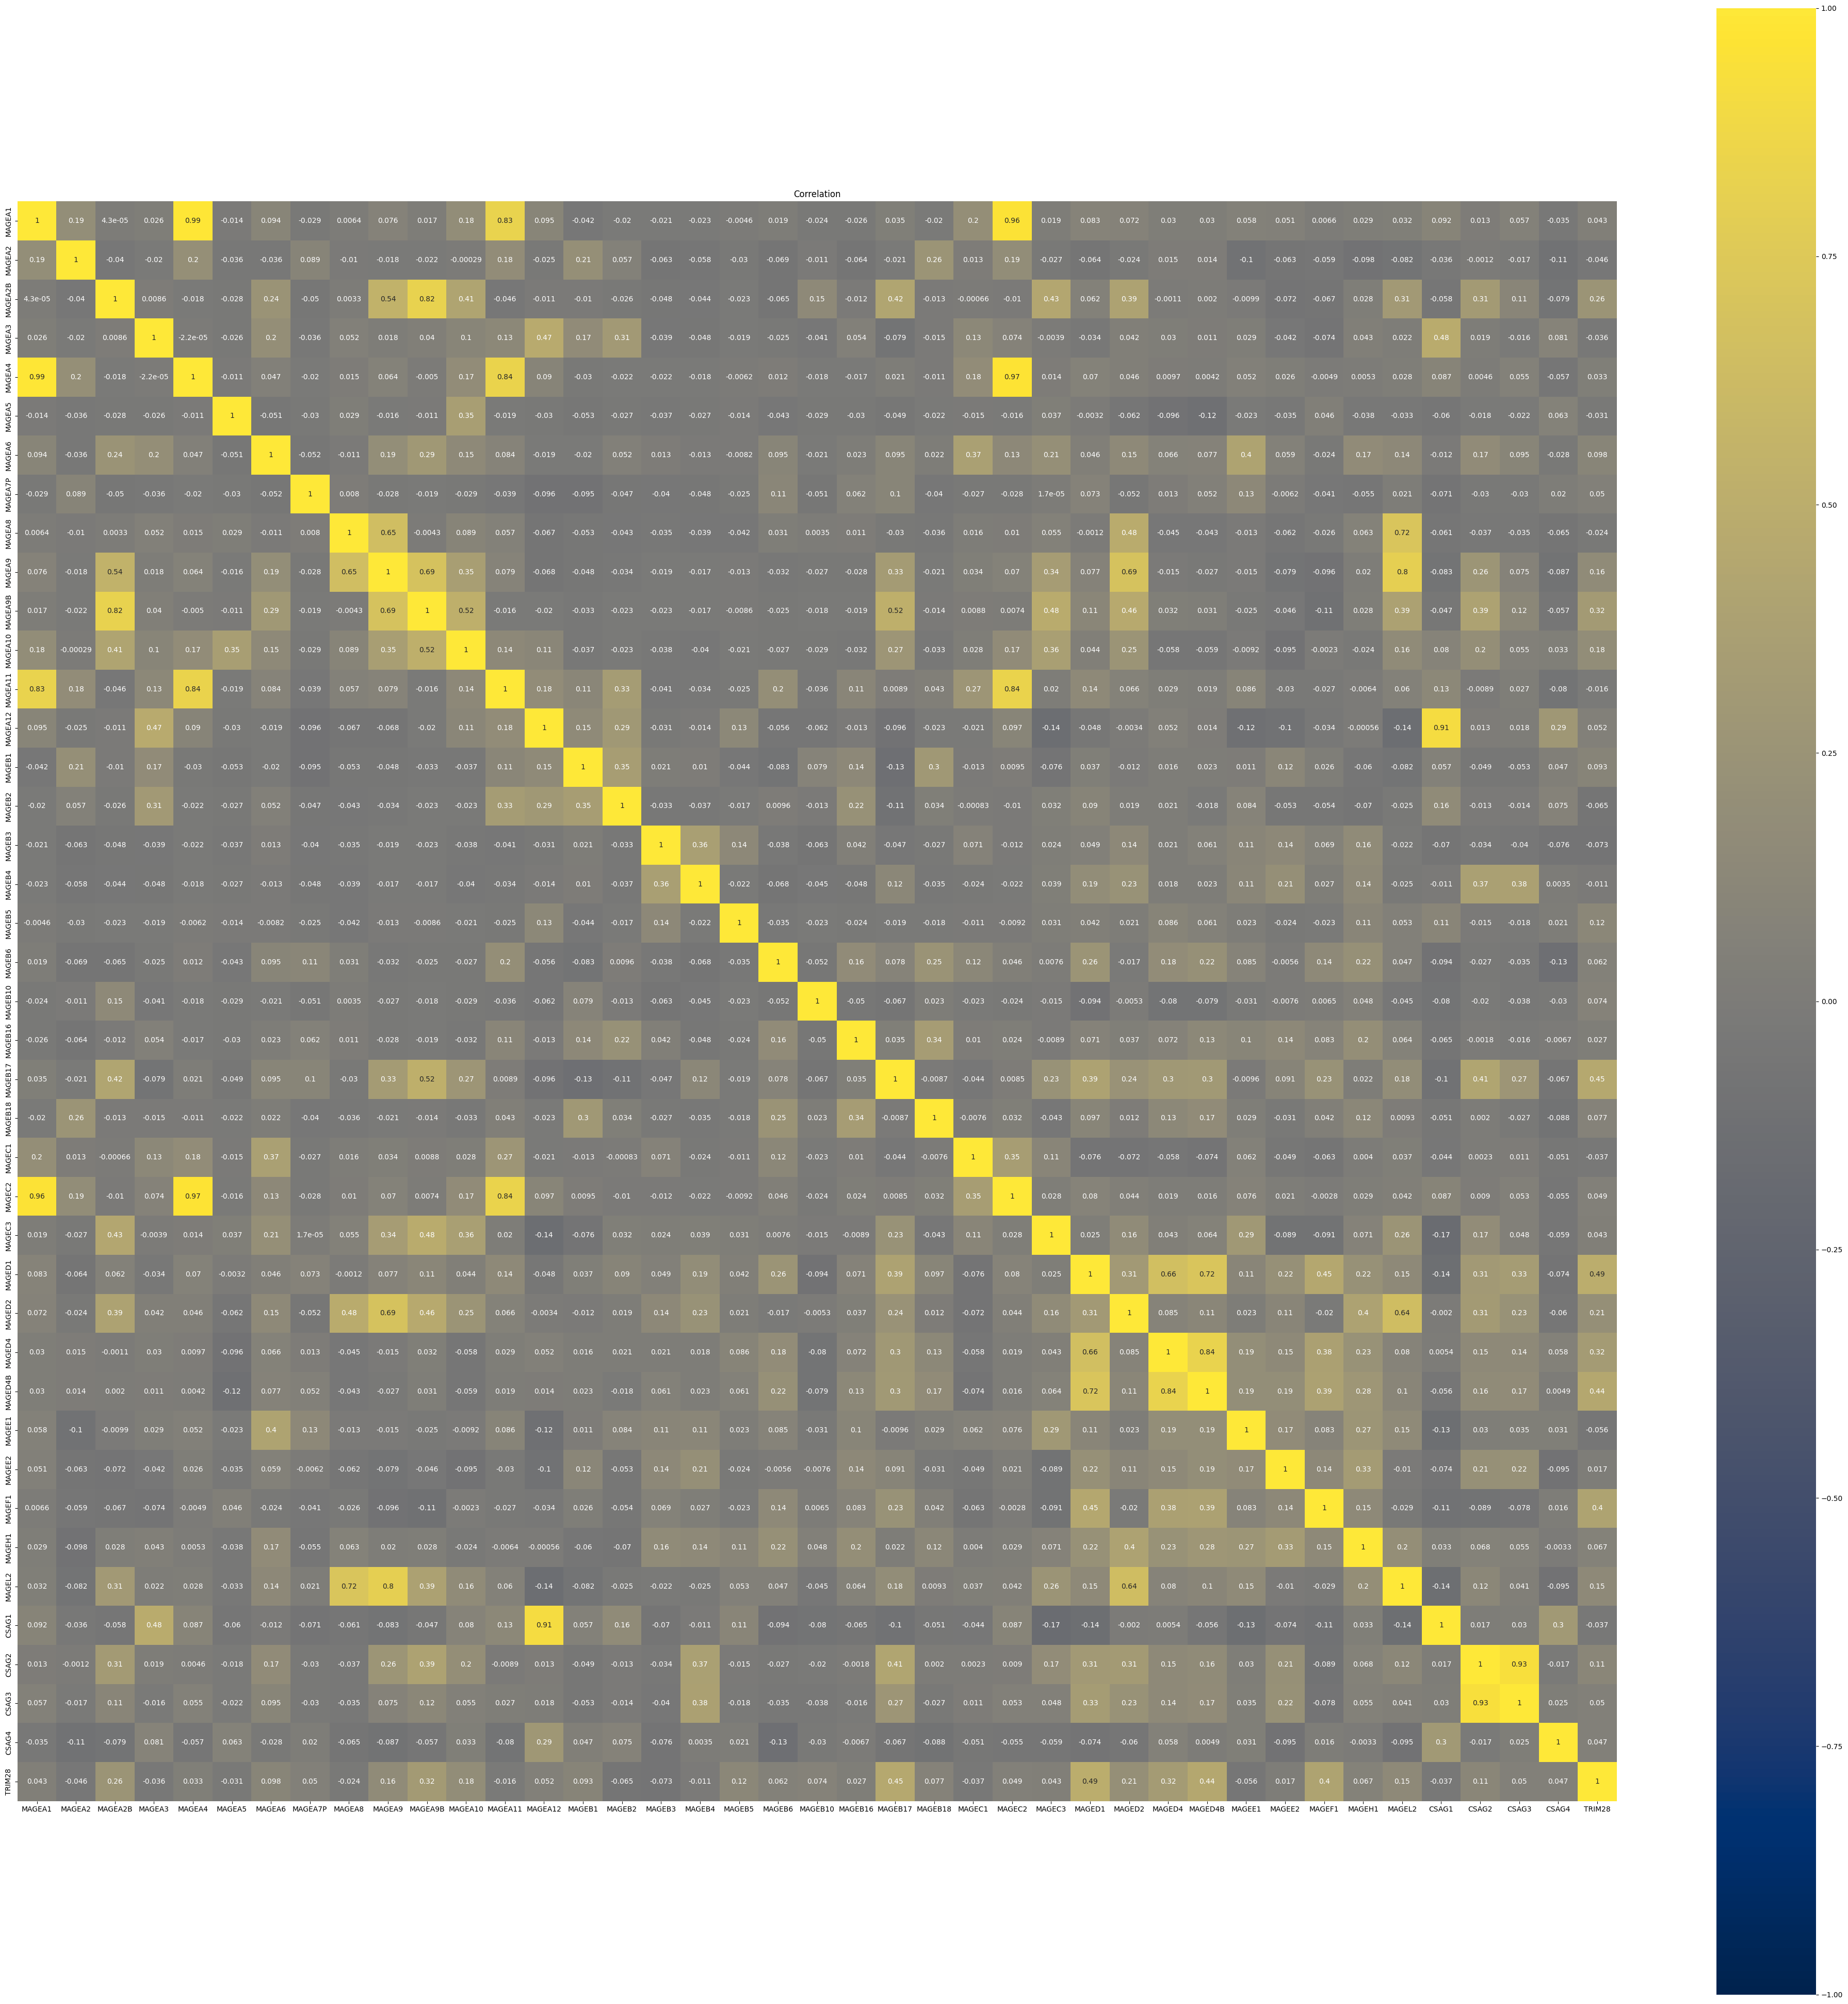

In [11]:
#Perform correlation (Pearson)
correlation = df_numeric.corr()
plt.figure(figsize = (50,50))
ax = sns.heatmap(correlation, vmax = 1, vmin = -1, square=True , annot=True, cmap = 'cividis') #Correlations from -1 to 1m change to vmin
correlation.to_csv('MAGEsPearsonCorrelation.csv')
plt.title('Correlation')
plt.show()

In [12]:
#Obtain top correlations. Functions to calculate.
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_all_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [13]:
print(get_top_abs_correlations(df_numeric, 14))

MAGEA1   MAGEA4     0.985519
MAGEA4   MAGEC2     0.968048
MAGEA1   MAGEC2     0.959018
CSAG2    CSAG3      0.934754
MAGEA12  CSAG1      0.907400
MAGEA11  MAGEC2     0.841618
MAGEA4   MAGEA11    0.838770
MAGED4   MAGED4B    0.835517
MAGEA1   MAGEA11    0.829848
MAGEA2B  MAGEA9B    0.822867
MAGEA9   MAGEL2     0.804245
MAGEA8   MAGEL2     0.715260
MAGED1   MAGED4B    0.715195
MAGEA9   MAGEA9B    0.691784
dtype: float64


<h1><font color="#004D7F" size=4>2.2 Distribution of TPMs.</font></h1>

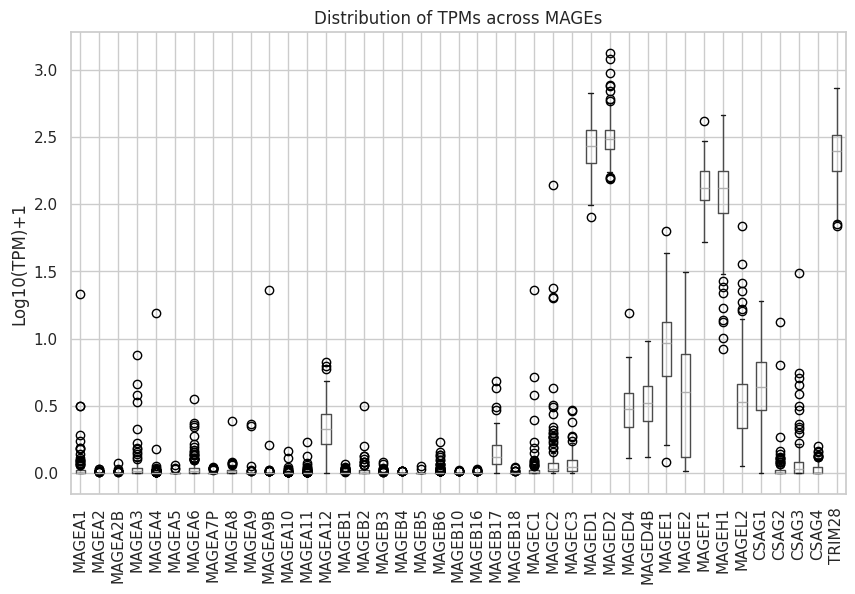

In [25]:
plt.figure(figsize=(10, 6))
df_numeric_log10 = np.log10(df_numeric+1)
df_numeric_log10.boxplot(rot=90)
plt.title('Distribution of TPMs across MAGEs')
plt.ylabel('Log10(TPM)+1')
plt.show()

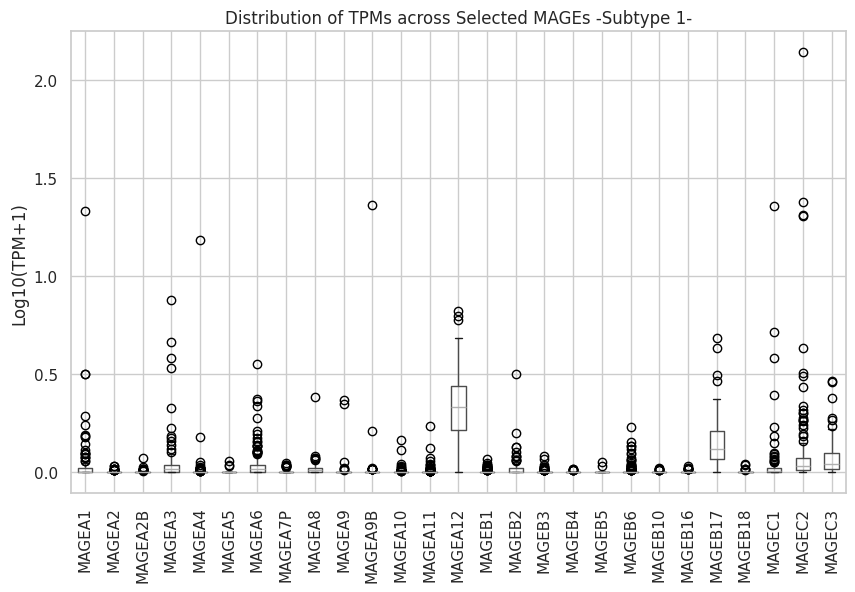

In [28]:
# Define the order of MAGE genes to include
mage_genes_subset = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3"
]
# Filter dataframe to include only the specified MAGE genes
df_numeric_subset = df_numeric[mage_genes_subset]
# Plotting
plt.figure(figsize=(10, 6))
df_numeric_log10 = np.log10(df_numeric_subset + 1)
df_numeric_log10.boxplot(rot=90)
plt.title('Distribution of TPMs across Selected MAGEs -Subtype 1-')
plt.ylabel('Log10(TPM+1)')
plt.show()

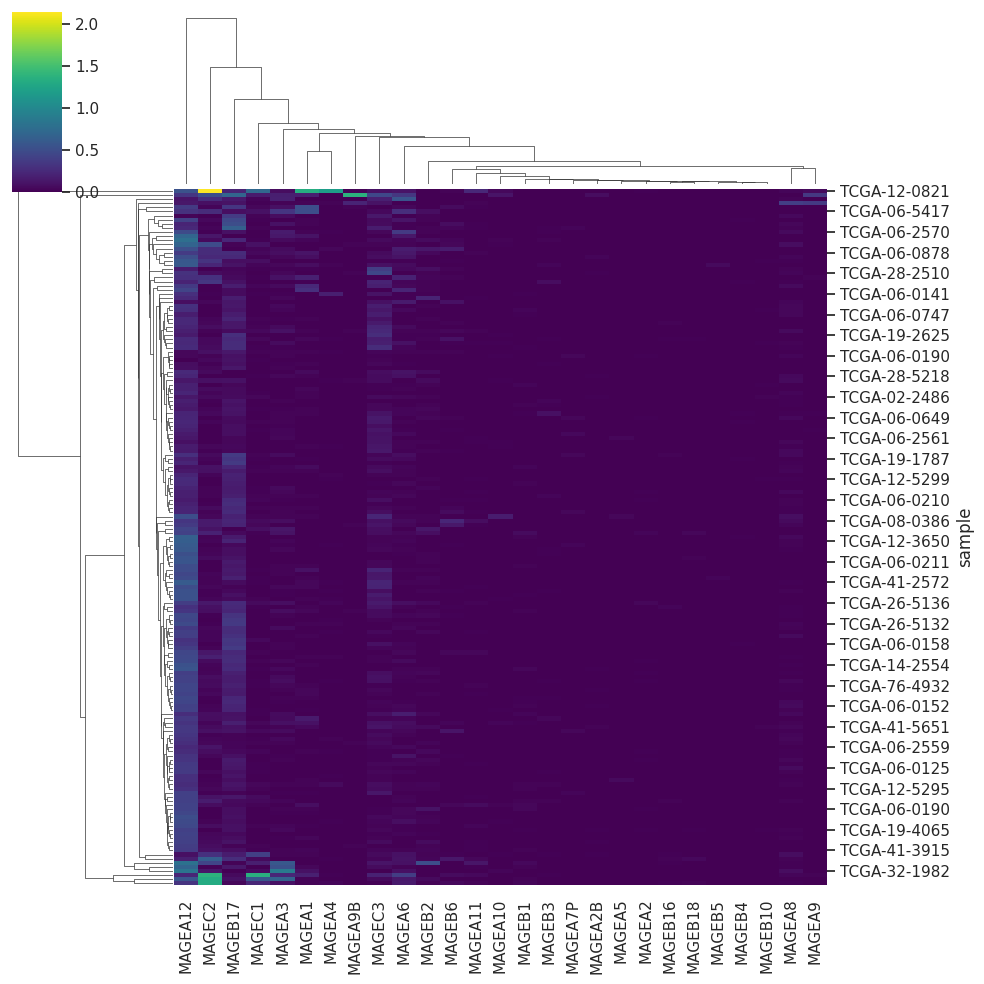

In [31]:
# Generate a clustered heatmap
sns.clustermap(df_numeric_log10, cmap="viridis", figsize=(10, 10))
plt.show()

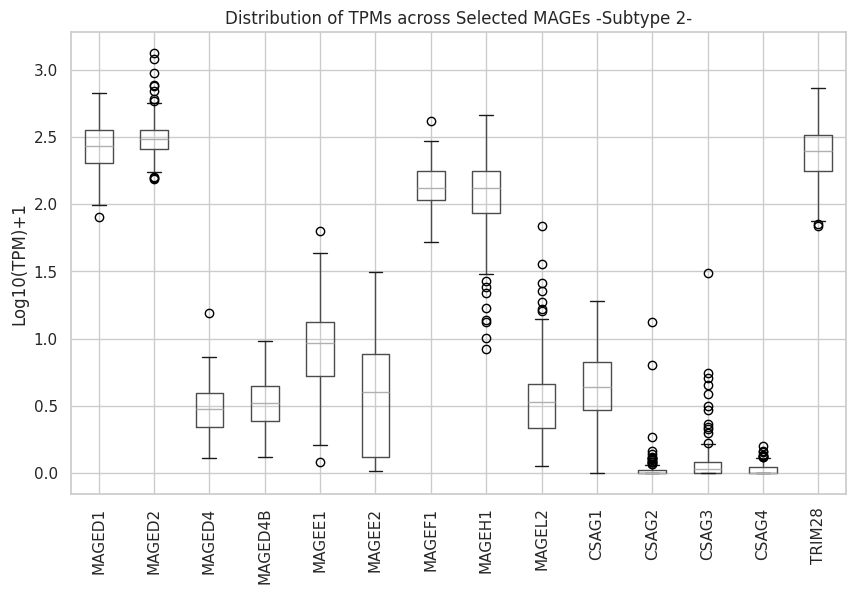

In [32]:
# Define the order of MAGE genes to include
mage_genes_subset = [
    "MAGED1", "MAGED2", "MAGED4", "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", 
    "CSAG3", "CSAG4", "TRIM28"
]
# Filter dataframe to include only the specified MAGE genes
df_numeric_subset = df_numeric[mage_genes_subset]
# Plotting
plt.figure(figsize=(10, 6))
df_numeric_log10 = np.log10(df_numeric_subset + 1)
df_numeric_log10.boxplot(rot=90)
plt.title('Distribution of TPMs across Selected MAGEs -Subtype 2-')
plt.ylabel('Log10(TPM)+1')
plt.show()

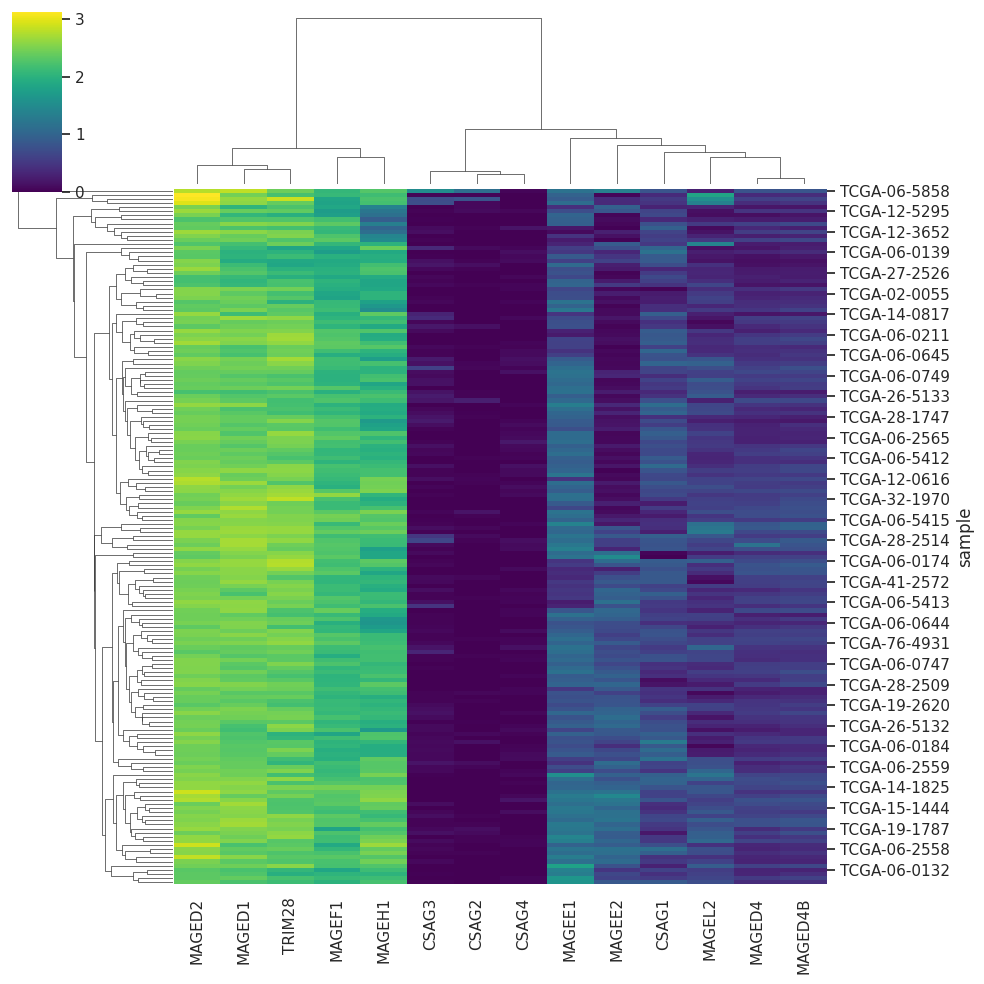

In [33]:
# Generate a clustered heatmap
sns.clustermap(df_numeric_log10, cmap="viridis", figsize=(10, 10))
plt.show()

<h1><font color="#004D7F" size=4>2.3 Composition of Positive and Negative Tumors by MAGEs.</font></h1>

In [17]:
no_zero = df_numeric.astype(bool).sum(axis=0)
zero = df_numeric.shape[0] - no_zero
# New df to order output
output_df = pd.DataFrame({'Positive_counts': no_zero, 'Negative_counts': zero})
output_df['Total_counts'] = output_df['Positive_counts'] + output_df['Negative_counts']
# Calculate percentages
percentage_df = output_df[['Positive_counts', 'Negative_counts']].div(output_df['Total_counts'], axis=0) * 100
# Concatenate percentages with original DataFrame
output_df = pd.concat([output_df, percentage_df.add_suffix('_percentage')], axis=1)
# Sort DataFrame by column names (alphabetical order)
output_df = output_df.sort_index()
finalTable= output_df[['Positive_counts','Positive_counts_percentage','Negative_counts','Negative_counts_percentage']]
finalTable=finalTable.round(1)
finalTable=finalTable.loc[column_order]
finalTable.to_csv('MAGEsComposition.csv')
finalTable.head(3)

,Positive_counts,Positive_counts_percentage,Negative_counts,Negative_counts_percentage
MAGEA1,73,43.2,96,56.8
MAGEA2,14,8.3,155,91.7
MAGEA2B,13,7.7,156,92.3


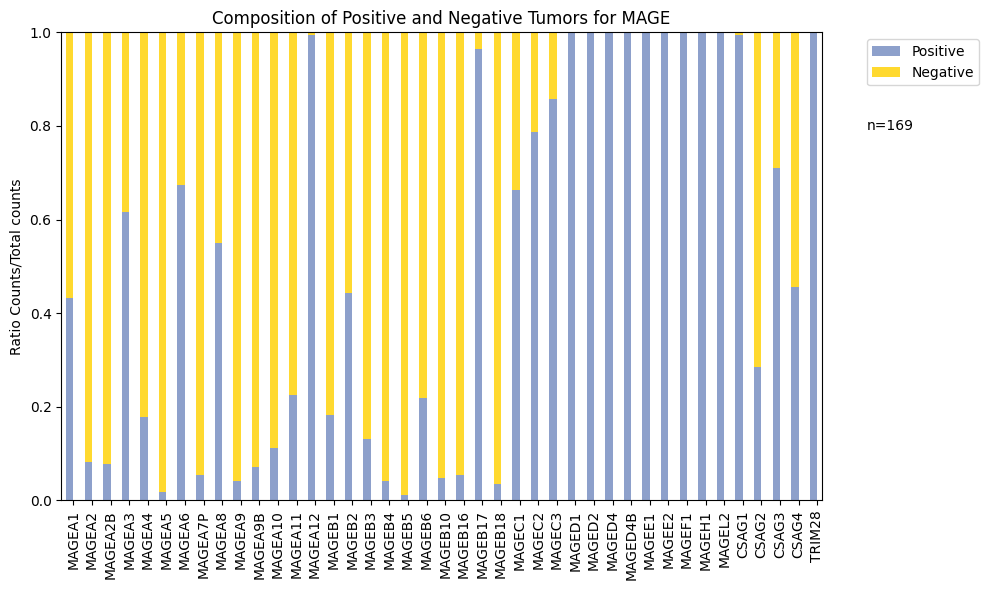

In [18]:
# Normalization
total_counts = no_zero + zero
positive_normalized = no_zero / total_counts
positive_normalized= positive_normalized[column_order]
negative_normalized = zero / total_counts
negative_normalized= negative_normalized[column_order]
# Set colors
colors_pastel = sns.color_palette("Set2")
# Stacked barplot
plt.figure(figsize=(10, 6))
positive_normalized.plot(kind='bar', color=colors_pastel[2], width=0.4, position=1, label='Positive')
negative_normalized.plot(kind='bar', color=colors_pastel[5], width=0.4, position=1, bottom=positive_normalized, label='Negative')
plt.title('Composition of Positive and Negative Tumors for MAGE')
plt.ylabel('Ratio Counts/Total counts')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.text(1.09, 0.8, 'n=169', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

<h1><font color="#004D7F" size=4>2.4. Overview clinical data.</font></h1>

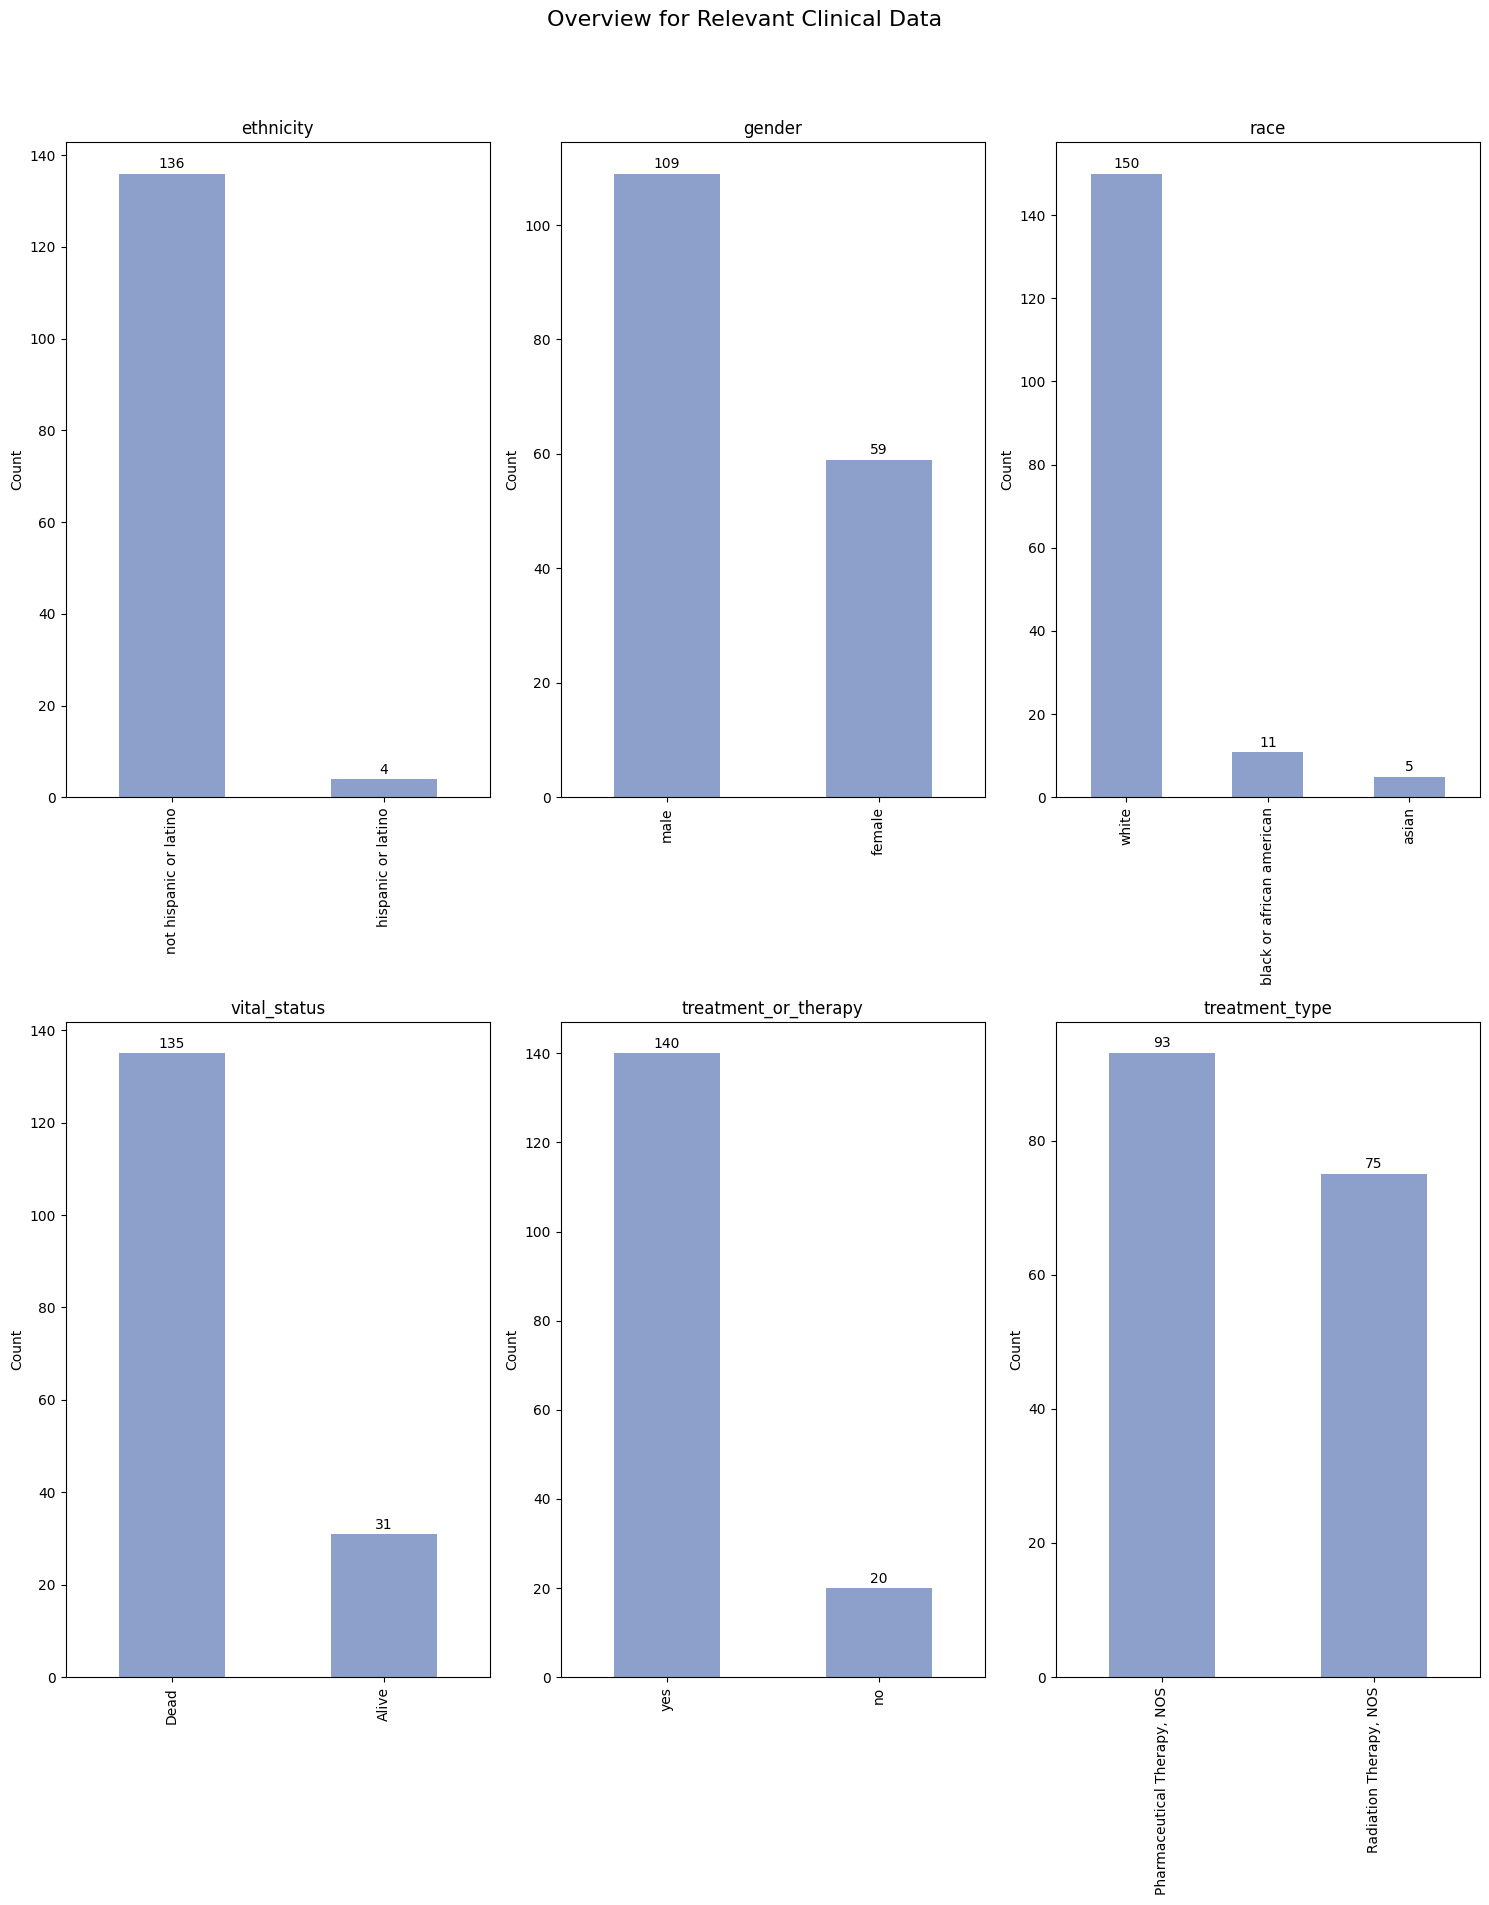

In [19]:
df_filled = df.copy()
# Define columns for bar plots
columns_bar = ['ethnicity', 'gender', 'race', 'vital_status', 'treatment_or_therapy', 'treatment_type']
# Calculate the number of rows and columns needed for subplots
num_cols_bar = 3  # Number of columns in the subplot grid for bar plots
num_rows_bar = (len(columns_bar) + num_cols_bar - 1) // num_cols_bar  # Calculate the number of rows needed
# Create a figure and set its size
plt.figure(figsize=(15, 20))
# Set a title for the entire figure
plt.suptitle('Overview for Relevant Clinical Data', fontsize=16)
# Loop through each column and create a subplot
colors_pastel = sns.color_palette("Set2")
for i, column in enumerate(columns_bar, 1):
    plt.subplot(num_rows_bar, num_cols_bar, i)
    # Plot bar plot for the current column
    counts = df_filled[column].value_counts()
    counts.plot(kind='bar', color=colors_pastel[2])
    # Annotate each bar with the count value if possible
    for j, count in enumerate(counts):
        plt.text(j, count + 0.5, str(count), ha='center', va='bottom')
    # Remove x-axis label
    plt.xlabel('')
    # Set y-axis label
    plt.ylabel('Count')
    # Set title for the subplot
    plt.title(column)
# Adjust the layout to prevent overlapping of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the plot
plt.show()

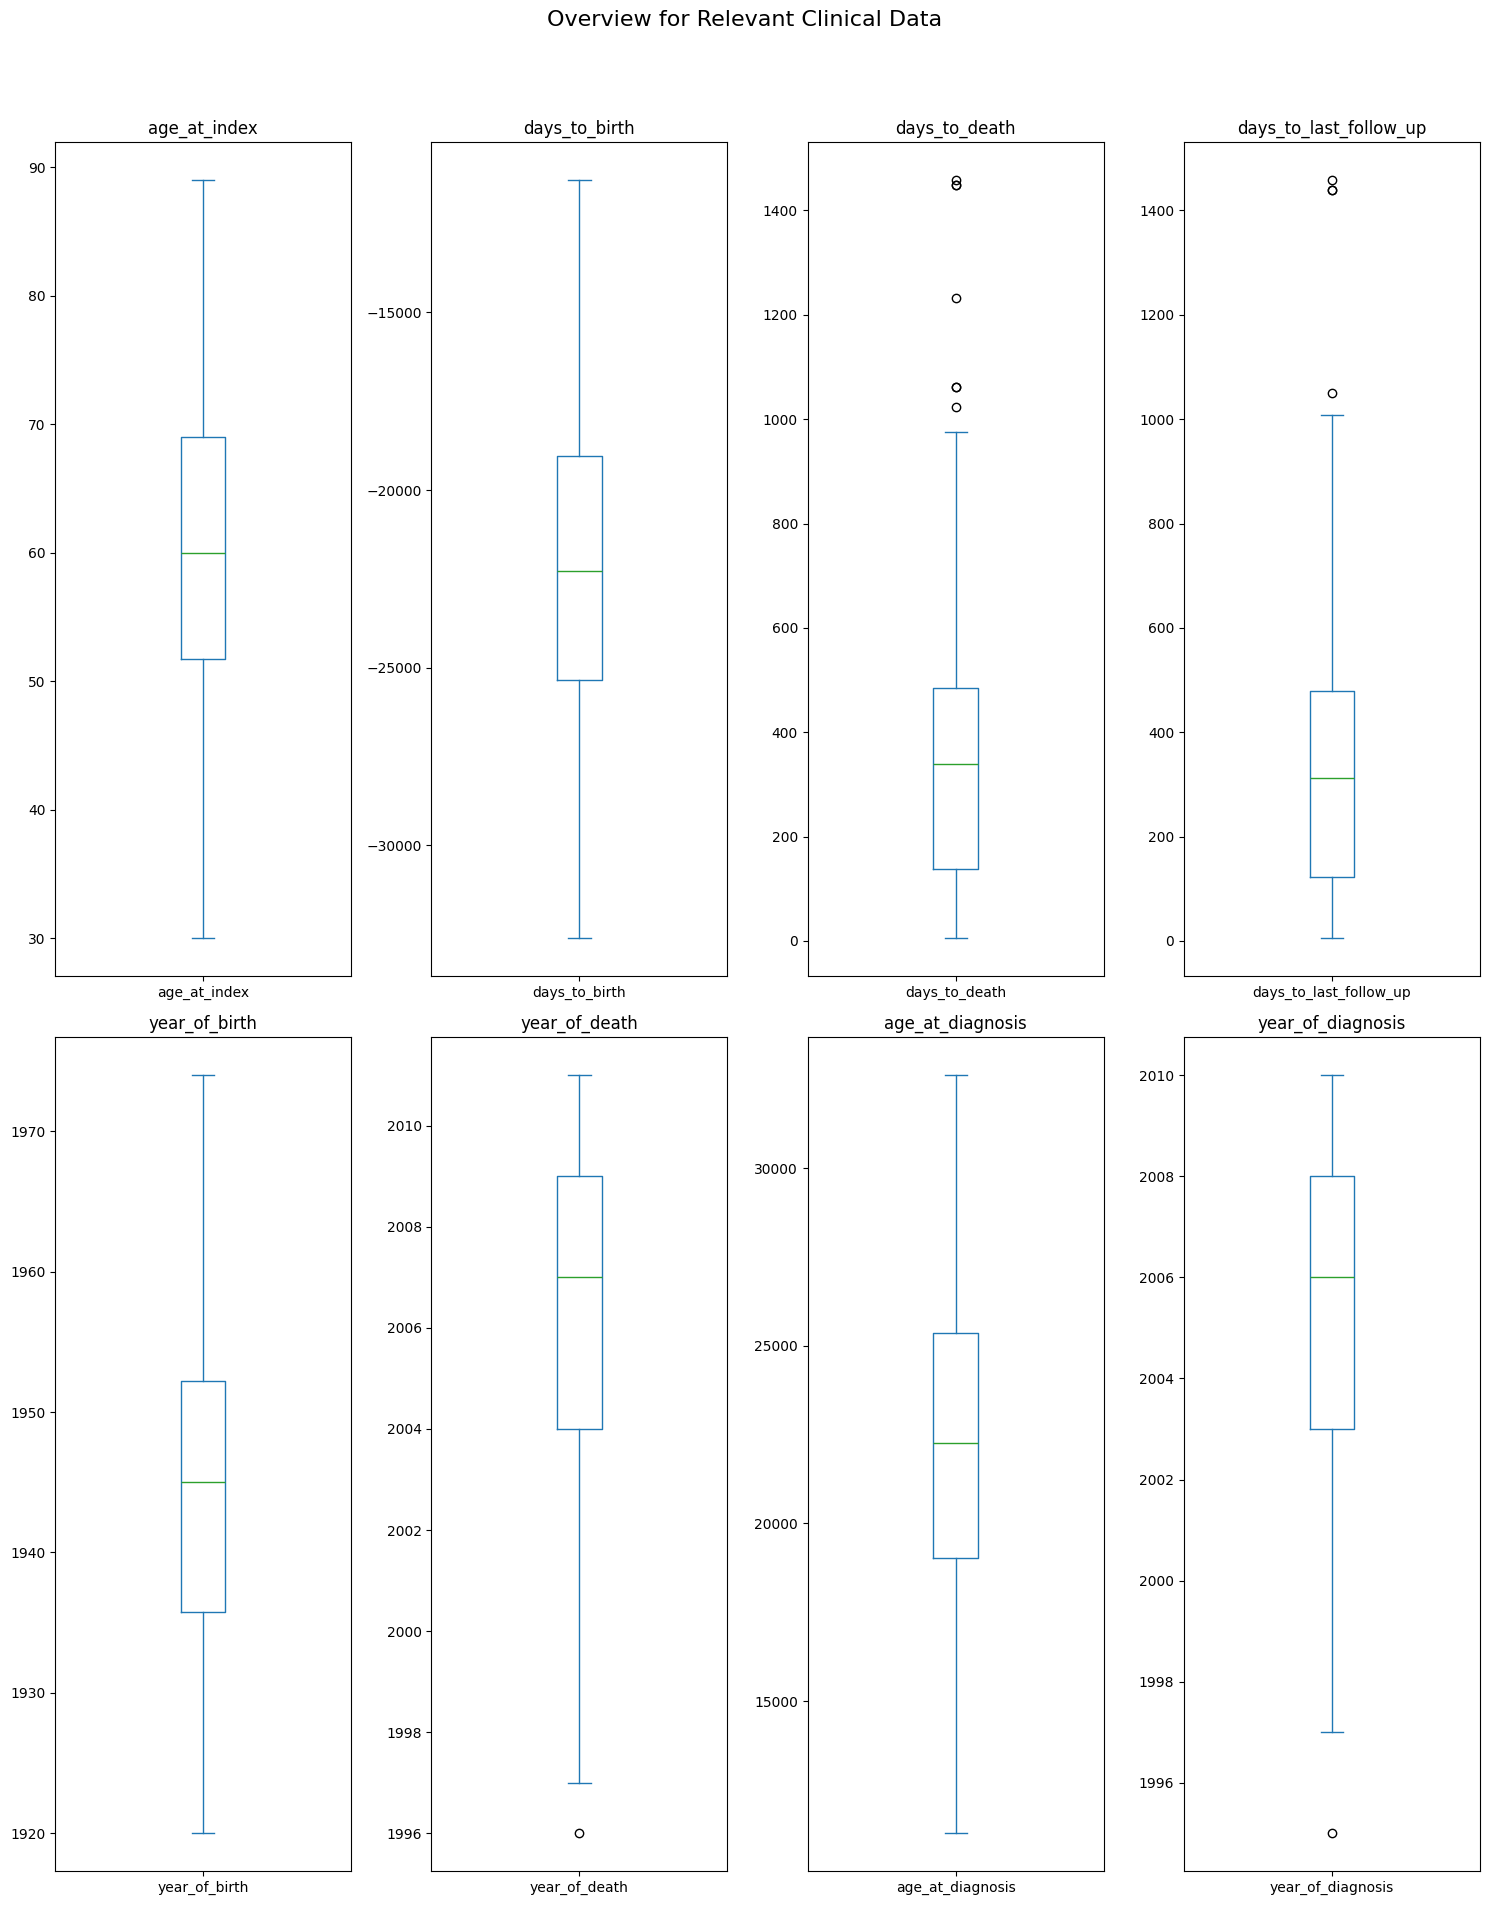

In [20]:
# Define columns for boxplots
columns_box = ['age_at_index', 'days_to_birth', 'days_to_death', 'days_to_last_follow_up', 'year_of_birth', 'year_of_death',
               'age_at_diagnosis', 'year_of_diagnosis']
# Remove NaN values from specified columns
df_filled = df_filled.dropna(subset=columns_box)
# Calculate the number of rows and columns needed for subplots
num_cols_box = 4  # Number of columns in the subplot grid for bar plots
num_rows_box = (len(columns_box) + num_cols_box - 1) // num_cols_box  # Calculate the number of rows needed
# Create a figure and set its size
plt.figure(figsize=(15, 20))
# Set a title for the entire figure
plt.suptitle('Overview for Relevant Clinical Data', fontsize=16)
# Loop through each column and create a subplot
for i, column in enumerate(columns_box, 1):
    plt.subplot(num_rows_box, num_cols_box, i)
    # Plot box plot for the current column without 0 values
    df_column = pd.to_numeric(df_filled[column], errors='coerce')
    df_column = df_column[df_column != 0]
    df_column.plot(kind='box')
    # Set subplot title
    plt.title(column)
# Adjust the layout to prevent overlapping of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the plot
plt.show()

In [21]:
genes = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28"
]
# Extract unique categories from the 'gender' column
genders = df['gender'].unique()
# Initialize a dictionary to store counts
counts_dict = {'Gene': [], 'Gender': [], 'Positive': [], 'Negative': []}
# Iterate over each MAGE gene and sex
for gene in genes:
    for gender in genders:
        # Filter dataframe for the current MAGE gene and sex
        filtered_df = df[(df[gene] > 0) & (df['gender'] == gender)]   
        # Count positive and negative cases
        positive_count = filtered_df.shape[0]
        negative_count = df[(df[gene] == 0) & (df['gender'] == gender)].shape[0]
        # Append counts to the dictionary
        counts_dict['Gene'].append(gene)
        counts_dict['Gender'].append(gender)
        counts_dict['Positive'].append(positive_count)
        counts_dict['Negative'].append(negative_count)

# Create a new dataframe from the counts dictionary
counts_df = pd.DataFrame(counts_dict)
# Display the resulting dataframe
print(counts_df)

       Gene  Gender  Positive  Negative
0    MAGEA1    male        46        63
1    MAGEA1  female        27        32
2    MAGEA1     NaN         0         0
3    MAGEA2    male         8       101
4    MAGEA2  female         6        53
..      ...     ...       ...       ...
118   CSAG4  female        28        31
119   CSAG4     NaN         0         0
120  TRIM28    male       109         0
121  TRIM28  female        59         0
122  TRIM28     NaN         0         0

[123 rows x 4 columns]


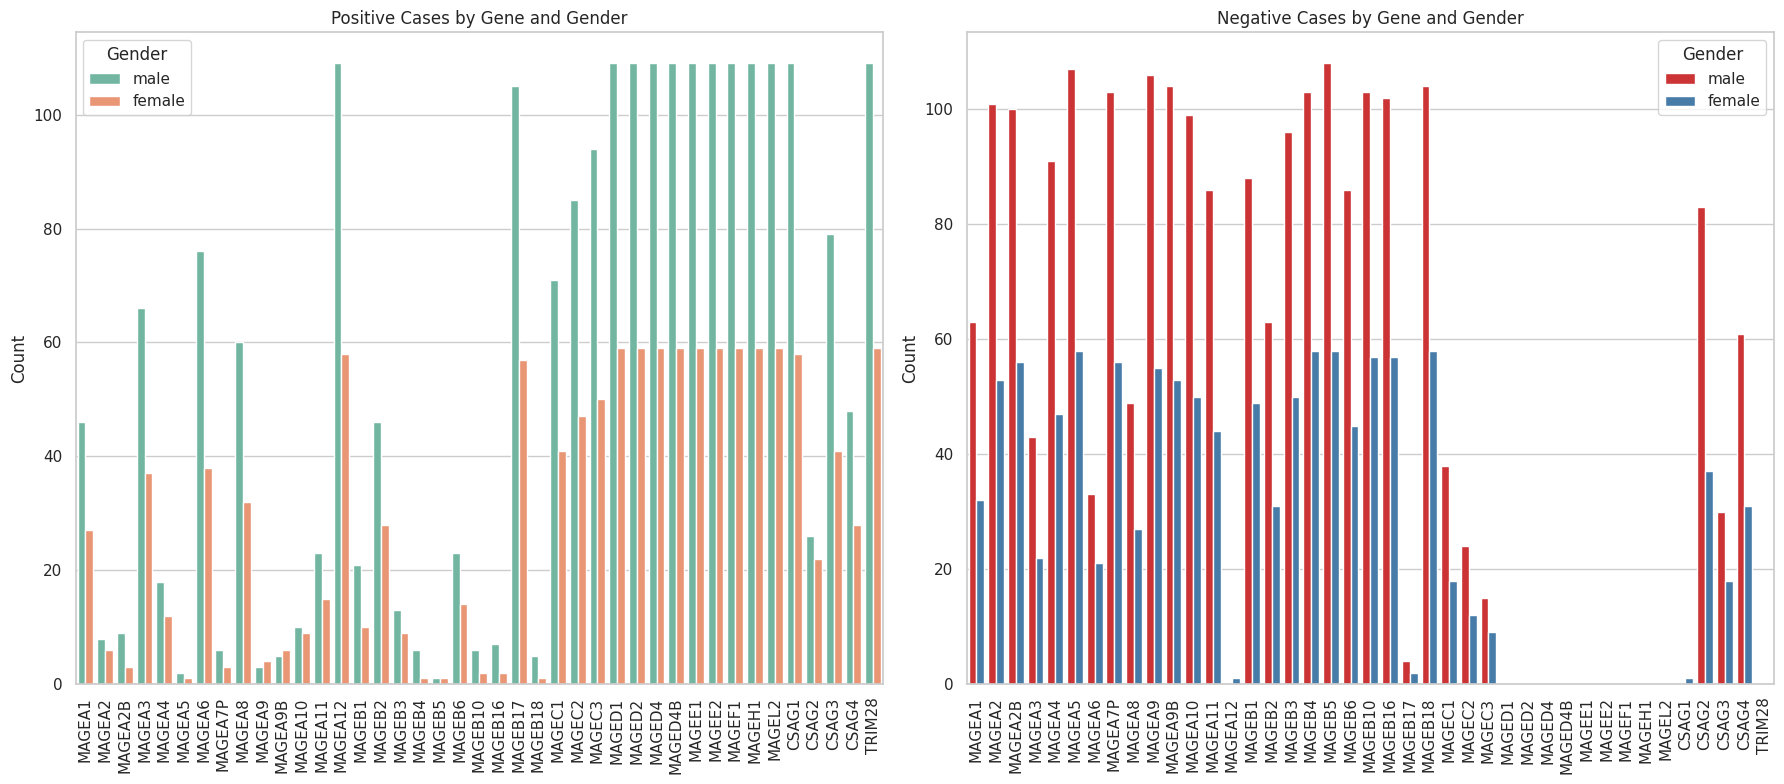

In [22]:
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot the first grouped bar plot
sns.barplot(ax=axes[0], x='Gene', y='Positive', hue='Gender', data=counts_df, palette='Set2', errorbar=None)
axes[0].set_title('Positive Cases by Gene and Gender')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(title='Gender')

# Plot the second grouped bar plot
sns.barplot(ax=axes[1], x='Gene', y='Negative', hue='Gender', data=counts_df, palette='Set1', errorbar=None)
axes[1].set_title('Negative Cases by Gene and Gender')
axes[1].set_xlabel('')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(title='Gender')

plt.tight_layout()
plt.show()

<h1><font color="#004D7F" size=5>3. Complex Data exploration</font></h1>

<h1><font color="#004D7F" size=4>3.1. PCA Tumors against categorical (clinical) variables.</font></h1>

Analyzing target column: gender
Explained Variance Ratio for PCA 1 with gender as target: [0.15027782 0.12863008]
Explained Variance Ratio for PCA 2 with gender as target: [0.35184898 0.19015397] 



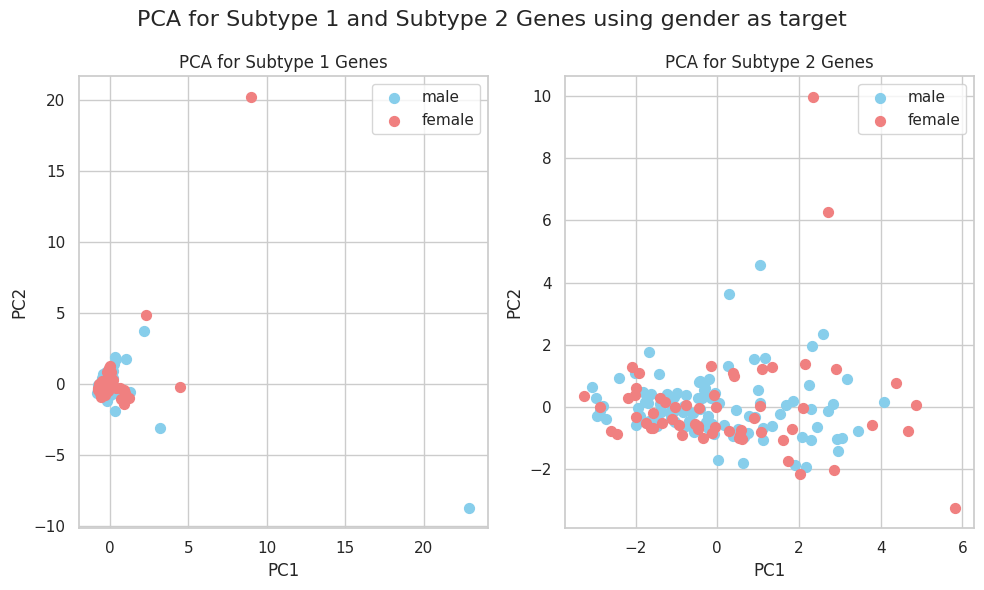

Analyzing target column: vital_status
Explained Variance Ratio for PCA 1 with vital_status as target: [0.15048251 0.13005496]
Explained Variance Ratio for PCA 2 with vital_status as target: [0.35138758 0.19060614] 



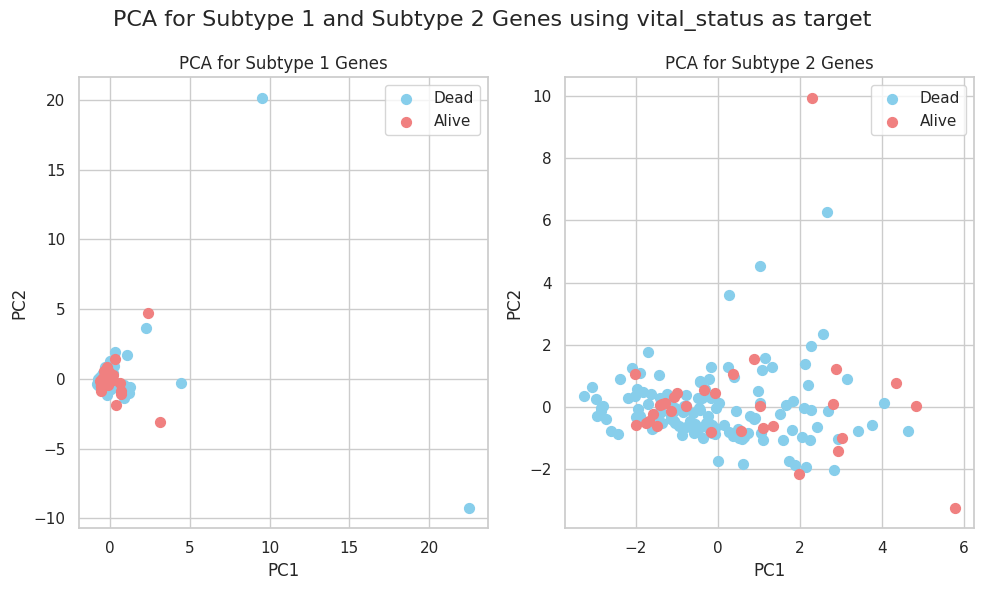

Analyzing target column: ethnicity
Explained Variance Ratio for PCA 1 with ethnicity as target: [0.15021819 0.10756008]
Explained Variance Ratio for PCA 2 with ethnicity as target: [0.36155321 0.18701306] 



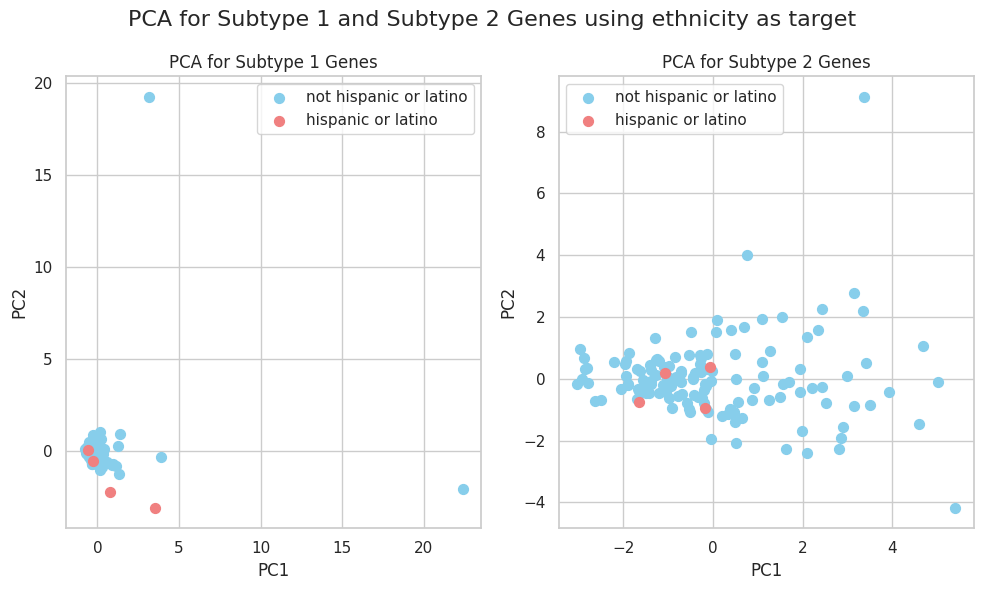

Analyzing target column: treatment_type
Explained Variance Ratio for PCA 1 with treatment_type as target: [0.15027782 0.12863008]
Explained Variance Ratio for PCA 2 with treatment_type as target: [0.35184898 0.19015397] 



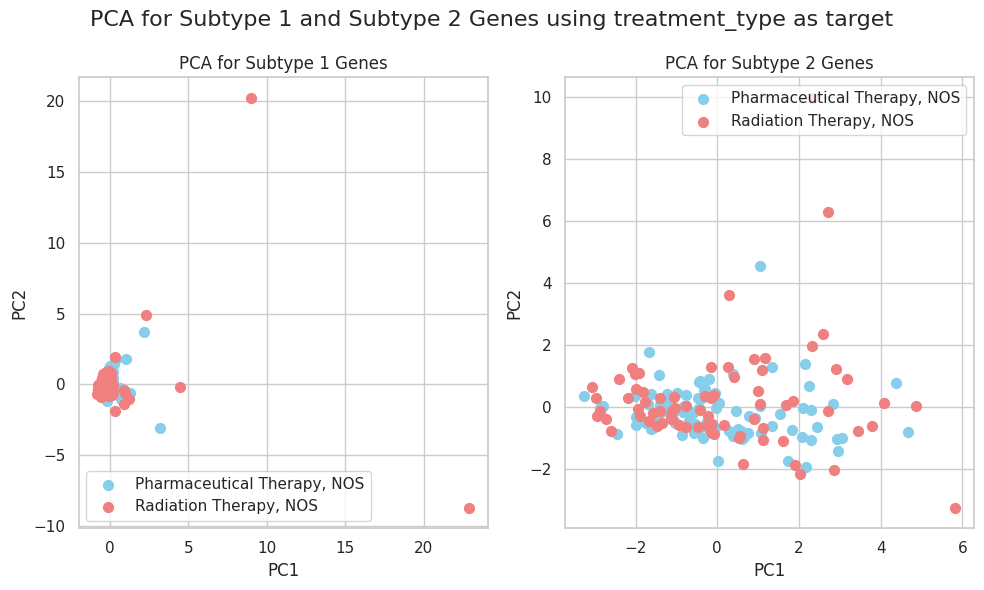

In [23]:
# Load dataset
column_order = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
                "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
                "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "MAGED4",
                "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", 'gender', 'vital_status', 'ethnicity', 'treatment_type']
# Subsample the DataFrame
df_gender = df[column_order].copy()
# Subtype 1 genes
subtype1_genes = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3"
]
# Subtype 2 genes
subtype2_genes = [
    "MAGED1", "MAGED2", "MAGED4", "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2"
]
# List of target columns
target_columns = ['gender','vital_status', 'ethnicity', 'treatment_type']
for target_column in target_columns:
    print("Analyzing target column:", target_column)
    # Separating subtype 1 and subtype 2 genes along with target column
    subtype1_data = df_gender.loc[:, subtype1_genes + [target_column]].copy()
    subtype2_data = df_gender.loc[:, subtype2_genes + [target_column]].copy()
    # Drop rows with NaN values
    subtype1_data.dropna(inplace=True)
    subtype2_data.dropna(inplace=True)
    # Standardizing the features for both subtypes
    subtype1_data.iloc[:, :-1] = StandardScaler().fit_transform(subtype1_data.iloc[:, :-1])
    subtype2_data.iloc[:, :-1] = StandardScaler().fit_transform(subtype2_data.iloc[:, :-1])
    # Reset index to avoid duplicate labels
    subtype1_data.reset_index(drop=True, inplace=True)
    subtype2_data.reset_index(drop=True, inplace=True)
    # PCA with 2 components for subtype 1 genes
    pca1 = PCA(n_components=2)
    principalComponents1 = pca1.fit_transform(subtype1_data.iloc[:, :-1])
    principalDf1 = pd.DataFrame(data=principalComponents1, columns=['principal component 1', 'principal component 2'])
    # Adding target column to the PCA DataFrame for subtype 1
    principalDf1[target_column] = subtype1_data[target_column]
    # Explained variance ratio for PCA 1
    print("Explained Variance Ratio for PCA 1 with", target_column, "as target:", pca1.explained_variance_ratio_)
    # PCA with 2 components for subtype 2 genes
    pca2 = PCA(n_components=2)
    principalComponents2 = pca2.fit_transform(subtype2_data.iloc[:, :-1])
    principalDf2 = pd.DataFrame(data=principalComponents2, columns=['principal component 1', 'principal component 2'])
    # Adding target column to the PCA DataFrame for subtype 2
    principalDf2[target_column] = subtype2_data[target_column]
    # Explained variance ratio for PCA 2
    print("Explained Variance Ratio for PCA 2 with", target_column, "as target:", pca2.explained_variance_ratio_, "\n")
    # Plotting the PCA results in 2D for subtype 1 genes
    plt.figure(figsize=(10, 6))
    plt.suptitle("PCA for Subtype 1 and Subtype 2 Genes using " + target_column + " as target", fontsize=16)
    plt.subplot(1, 2, 1)
    targets = subtype1_data[target_column].unique()
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lavender']  # Adjust colors if more unique categories
    for target, color in zip(targets, colors):
        indicesToKeep = principalDf1[target_column] == target
        plt.scatter(principalDf1.loc[indicesToKeep, 'principal component 1'],
                    principalDf1.loc[indicesToKeep, 'principal component 2'], c=color, s=50)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA for Subtype 1 Genes')
    plt.legend(targets)
    # Plotting the PCA results in 2D for subtype 2 genes
    plt.subplot(1, 2, 2)
    for target, color in zip(targets, colors):
        indicesToKeep = principalDf2[target_column] == target
        plt.scatter(principalDf2.loc[indicesToKeep, 'principal component 1'],
                    principalDf2.loc[indicesToKeep, 'principal component 2'], c=color, s=50)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA for Subtype 2 Genes')
    plt.legend(targets)
    plt.tight_layout()
    plt.show()

<h1><font color="#004D7F" size=4>3.2. Clustering of Tumors.</font></h1>

In [34]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)
# Define a range of k values to test
k_values = range(2, 11)  # Test for 2 to 10 clusters

# Initialize a dictionary to store silhouette scores for each k
silhouette_scores = {}

for k in k_values:
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(scaled_data)
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(scaled_data, df['Cluster'])
    silhouette_scores[k] = silhouette_avg

# Find the k with the highest silhouette score
best_k = max(silhouette_scores, key=silhouette_scores.get)

print("Best k:", best_k)
print("Silhouette Score:", silhouette_scores[best_k])

Best k: 2
Silhouette Score: 0.540633792091243


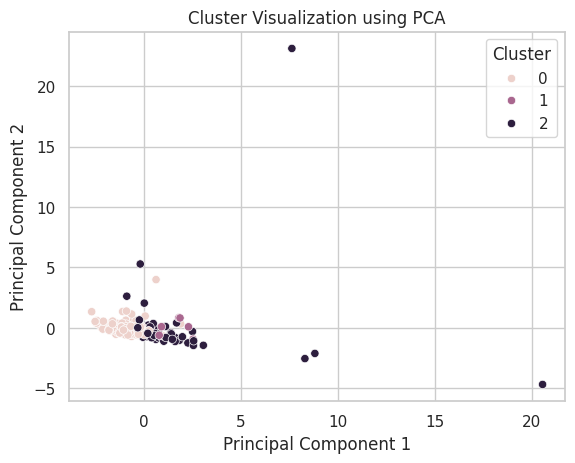

In [35]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Reset the index of df
df = df.reset_index(drop=True)

# Reduce data dimensionality to 2 dimensions using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Add the cluster labels to the reduced data
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

# Visualize the clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df)
plt.title('Cluster Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

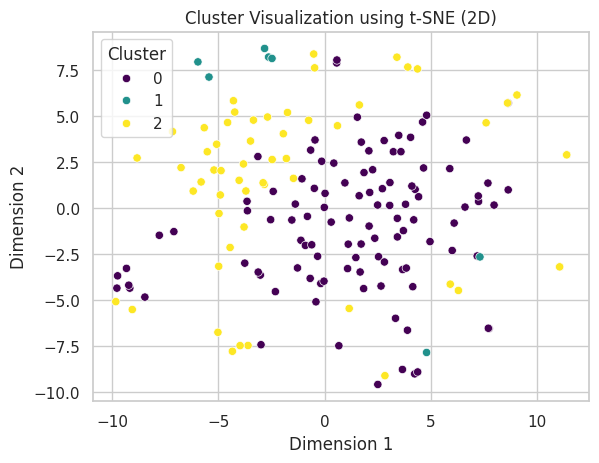

In [36]:
# Reduce data dimensionality to 2 dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled_data)

# Add the cluster labels to the reduced data
tsne_df = pd.DataFrame(tsne_data, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = df['Cluster']

# Visualize the clusters in 2D using t-SNE
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster', data=tsne_df, palette='viridis')
plt.title('Cluster Visualization using t-SNE (2D)')
plt.show()

<h1><font color="#004D7F" size=4>Extras</font></h1>

<h1><font color="#004D7F" size=4>PCA including all genes by gender</font></h1>

In [ ]:
# Load dataset
#column_order = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9","MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6","MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "MAGED4","MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28", 'gender']
column_order = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9","MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6","MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "MAGED4","MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", 'gender']
# Subsample the DataFrame
df_gender = df[column_order].copy()
features = column_order[:-1]  # Exclude the 'gender' column
# Separating out the features
x = df_gender.loc[:, features].values
# Separating out the target
y = df_gender.loc[:,['gender']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
# PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
# Resetting the index of df_gender
df_gender.reset_index(drop=True, inplace=True)
# Concatenating with the gender column
finalDf = pd.concat([principalDf, df_gender['gender']], axis=1)
# Plotting the PCA results in 2D
plt.figure(figsize=(4,3))
targets = ['male', 'female']  # Assuming 'gender' column values are 'Male' and 'Female'
colors = ['b', 'r']  # Blue for Male, Red for Female
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['gender'] == target
    plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                finalDf.loc[indicesToKeep, 'principal component 2'],
                c=color, s=50)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.legend(targets)
plt.title('PCA of Tumors ')
plt.show()